## Setup libs

In [1]:
import importlib
import brikasutils as bu
importlib.reload(bu)
import shared_utils as utils
from shared_utils import systemMsg, userMsg, assistantMsg
importlib.reload(utils)
import survey
importlib.reload(survey)
import persona
importlib.reload(persona)

import ollama
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os
import re
import time
import json
from typing import List
from openai import OpenAI

# **Analysis**

### Batch analysis

In [5]:
import json
import os
import survey
import pandas as pd
import re
import importlib
import shared_utils as utils
importlib.reload(utils)
import brikasutils as bu
importlib.reload(bu)

def see_if_column_valid(column_name, df, msg="Verification failed for"):
    dff = df[df[column_name].isna()]
    dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
    print(f"{msg}: {len(dff)} ({len(dfff)} unique)")
    return dfff

MOST_IMPORTANT_COLUMNS = ['sim_signature', 'run_number', "model", "survey_type", "base_sim_signature", "SUBJECT"]

In [6]:
# Index all simulation files
SIMULATIONS_DIR = "analysis/sims-final-1"

sim_runs = []
for root, dirs, files in os.walk(SIMULATIONS_DIR):
    for file in files:
        if file.split(".")[1] != "json":
            print(f"Invalid file (all must be json) {sim_run['path']}")

        sim_run = {}
        sim_run["SIMULATION_ID"] = file.split(".")[0]
        sim_run["path"] = os.path.join(root, file)
        with open(sim_run["path"], 'r') as f:
            sim = json.load(f)
        sim_run.update(sim["info"]["info"])
        sim_run.update(sim["info"]["settings"])
        sim_runs.append(sim_run)

df = pd.DataFrame(sim_runs)
df = df.dropna(axis=1, how='all')
print(f"Loaded {len(df)} simulation files")

Loaded 183 simulation files


### Infer/Get Needed Data

In [7]:
def infer_survey_type(row):
    if "survey_type" in row and not pd.isna(row["survey_type"]):
        if row["survey_type"] == "KanoSurvey":
            return "KanoSurvey"
        elif row["survey_type"] == "PersonalitySurvey":
            return "PersonalitySurvey"
        else:
            print("Unknown survey type" + row["survey_type"])

    if "prompt_count" in row and not pd.isna(row["prompt_count"]):
        if row["prompt_count"] == 50:
            return "PersonalitySurvey"
        elif row["prompt_count"] == 40:
            return "KanoSurvey"
        else:
            print("Unknown prompt count" + row["prompt_count"])

    return None

df["survey_type"] = df.apply(infer_survey_type, axis=1) 
df["survey_type"].value_counts()

# extract_run_number
def extract_run_number(sim_id):
    try:
        parts = sim_id.rsplit('_', 1)  # Attempt to split by the last underscore
        if len(parts) == 2:  # Check if the split was successful
            return pd.Series([parts[0], int(parts[-1])])
        else:
            print(f"Error while processing {sim_id}")
            return pd.Series([pd.NA, pd.NA])  # Return None for last_number if split fails
         
    except Exception as e:  # Generic exception handling
        print(f"Error while processing {sim_id}")
        return pd.Series([pd.NA, pd.NA])

df[['sim_signature', 'run_number']] = df['SIMULATION_ID'].apply(extract_run_number)

In [8]:
# infer_if_simulation_is_base
def infer_if_simulation_is_base(row):
    if row["sim_signature"][:4] == "base":
        return True
    return False
    
df["is_base"] = df.apply(infer_if_simulation_is_base, axis=1)

# Below: Vanity Print
dff = df[df["is_base"] == True]
dff = dff.sort_values(by=['sim_signature', 'run_number'])
dff = dff.dropna(axis=1, how='all')
dfff = dff.groupby("sim_signature").apply(lambda x: x[x['run_number'] == 1], include_groups=False)
print(f"Found {len(dff)} ({len(dfff)} unique) base simulations")

Found 12 (4 unique) base simulations


In [10]:
# Map simulations to their base
def map_simulation_to_base(row):
    if row["is_base"] == True:
        return "(base)"
    if row["survey_type"] == "KanoSurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_kano_v2_gpt35"

    if row["survey_type"] == "PersonalitySurvey" and row["model"] == "gpt-3.5-turbo":
        return "base_personality_v2_gpt35"

    if row["survey_type"] == "KanoSurvey" and (row["model"] == "llama3" or row["model"] == "llama3:70b"):
        return "base_kano_v2_llama3"

    if row["survey_type"] == "PersonalitySurvey" and (row["model"] == "llama3" or row["model"] == "llama3:70b"):
        return "base_personality_v2_llama3"
    
    return pd.NA
    
df["base_sim_signature"] = df.apply(map_simulation_to_base, axis=1)
dff = see_if_column_valid("base_sim_signature", df, "Missing mappings")
if len(dff) == 0:
    print("All mappings are valid")
else:
    print("Not all mappings are valid. See the missing mappings below")
    display(dff)

def infer_subject(row):
    if row["is_base"]:
        return "(base)"
    if "SUBJECT" in row and pd.notna(row["SUBJECT"]):
        if row["SUBJECT"] == "airidas" or row["SUBJECT"] == "Airidas" or row["SUBJECT"] == "airi":
            return "airidas"
        if row["SUBJECT"] == "elias" or row["SUBJECT"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['SUBJECT']}")
        return pd.NA
    if "subject" in row and pd.notna(row["subject"]):
        if row["subject"] == "airidas" or row["subject"] == "Airidas" or row["subject"] == "airi":
            return "airidas"
        if row["subject"] == "elias" or row["subject"] == "eli":
            return "elias"
        print(f"Unknown subject: {row['subject']}")
        return pd.NA
    if row["sim_signature"][:4] == "airi":
        return "airidas"
    if row["sim_signature"][:3] == "eli":
        return "elias"
    return pd.NA

df["SUBJECT"] = df.apply(infer_subject, axis=1)
dff = see_if_column_valid("SUBJECT", df, "Missing subjects")
if len(dff) == 0:
    print("All subjects are valid")
else:
    display(dff)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)


Missing mappings: 0 (0 unique)
All mappings are valid
Missing subjects: 0 (0 unique)
All subjects are valid


### Compute Scores

#### Setup

In [11]:
def get_surv_from_info(row):
    if row["survey_type"] == "KanoSurvey":
        return survey.KanoSurvey()
    elif row["survey_type"] == "PersonalitySurvey":
        return survey.PersonalitySurvey()
    else:
        raise Exception("Unknown survey type: " + row["survey_type"])

all_possible_asnwers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]
def extract_possible_answer(value):
    for phrase in all_possible_asnwers:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in all_possible_asnwers:
        return ""
    else:
        return value

def clean_simulation_QA(df) -> pd.DataFrame:
    df['answer'] = df['answer'].apply(lambda x: x.strip())
    for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
        df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
    df['answer'] = df['answer'].str.upper()
    df['answer'] = df['answer'].apply(extract_possible_answer)

    REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE"}
    df.iloc[:, 1:] = df.iloc[:, 1:].map(lambda x: REMAP_MISSING_E.get(x, x))

    PARTIAL_MATCH_REMAP = {"SOMEWHAT AG":"SOMEWHAT AGREE" }
    df["answer"] = df["answer"].apply(
        lambda answer: next((value for key, value in PARTIAL_MATCH_REMAP.items() if key in answer), answer)
    )

    # Update isValid
    df['isValid'] = df['answer'].apply(lambda x: x in all_possible_asnwers)

    # if all values in isValid is true, drop the column, else print a message
    if not df['isValid'].all():
        print("Warning, some answers were not valid. See df['isValid']")      

    return df

# Proces simulation output
def add_airidas_and_elias_answers(df, surv) -> pd.DataFrame:
    # Add airidas and elias answers
    air = surv.test_answers["airidas"]
    eli = surv.test_answers["elias"]

    # Sanity Check
    if len(air) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(air)} != {len(df)}. Suvey type: {str(type(surv))}")

    df.insert(2, "airidas", air[:len(df)])
    df.insert(3, "elias", eli[:len(df)])

    # Convert to uppercase
    if isinstance(surv, survey.KanoSurvey):
        df['answer'] = df['answer'].str.upper()
        df['airidas'] = df['airidas'].str.upper()
        df['elias'] = df['elias'].str.upper()
        
    return df

def remap_answers_to_integers(df, surv):
    # Sanity Check
    if len(surv.test_answers["airidas"]) != len(df):
        raise Exception(f"Survey and DF length mismatch {len(surv.test_answers['airidas']) } != {len(df)}. Check survey type.")

    if isinstance(surv, survey.KanoSurvey):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        df['answer'] = df['answer'].map(remap_dict)
        df['airidas'] = df['airidas'].map(remap_dict)
        df['elias'] = df['elias'].map(remap_dict)
    elif isinstance(surv, survey.PersonalitySurvey):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        df['answer'] = df['answer'].map(remap_dict)

    return df

def evaluate_single_simulation_run(df) -> dict:
    # compute the percentage of correct answers and average loss (MAE)
    result_data = {
        "p-corr_Airidas": df['answer'].corr(df['airidas']),
        "p-corr_Elias": df['answer'].corr(df['elias']),
        # Average of absolute residuals for Airidas
        "mean_residual_Airidas": (df['answer'] - df['airidas']).abs().sum() / len(df),
        # Average of absolute residuals for Elias
        "mean_residual_Elias": (df['answer'] - df['elias']).abs().sum() / len(df),
    }
    return result_data


ADD_TO_MOST_IMPORTANT_COLUMNS = ["p-corr_Airidas", "p-corr_Elias", "mean_residual_Airidas", "mean_residual_Elias"]
for col in ADD_TO_MOST_IMPORTANT_COLUMNS:
    if col not in MOST_IMPORTANT_COLUMNS:
        MOST_IMPORTANT_COLUMNS.append(col)  

#### Single Sim

In [231]:
sim_i = df.iloc[1]
print(sim_i["sim_signature"])
sim = utils.load_sim(sim_i["path"])
dfa = utils.dataframe_from_QA(sim["QA"])

surv = get_surv_from_info(sim_i)
dfa = clean_simulation_QA(dfa)
dfa = add_airidas_and_elias_answers(dfa, surv)
dfa = remap_answers_to_integers(dfa, surv)
res = evaluate_single_simulation_run(dfa)

<NA>
Using default Personality Survey CSV file: surveys/survey_personality-test.csv


In [233]:
df

,sim_signature,run_number,model,survey_type,p-corr_Airidas,p-corr_Elias,mean_residual_Airidas,mean_residual_Elias,SIMULATION_ID,survey,...,prompt_count,retrieval prompt,retrieval method,prompt method,tokens_in_chunks,CTX_limit,CHUNKS_COUNT_IN_CTX,OVERLAP_SIZE,CHUNK_SIZE,date
0,<NA>,<NA>,command-r-plus:104b-q2_K,PersonalitySurvey,0.249,0.243,1.20,1.34,eli-pers-hybrid-100-05-20_command-r-plus_104b-...,pers,...,50,openess conciousness extrovert aggreableness n...,hybrid,IMPERSONATE,695218,30000,20,5,100,2024-05-03_174918
1,<NA>,<NA>,command-r-plus:104b-q2_K,PersonalitySurvey,0.191,0.107,1.26,1.40,eli-pers-dynamic-200-05-09_command-r-plus_104b...,pers,...,50,openess conciousness extrovert aggreableness n...,dynamic,IMPERSONATE,1313092,30000,9,5,200,2024-05-03_160838
2,<NA>,<NA>,mixtral:8x22b-instruct-v0.1-q2_K,PersonalitySurvey,0.519,0.654,1.14,0.84,eli-pers-dynamic-100-05-20_mixtral_8x22b-instr...,pers,...,50,openess conciousness extrovert aggreableness n...,dynamic,IMPERSONATE,1360011,30000,20,5,100,2024-05-03_141503
3,<NA>,<NA>,mixtral:8x22b-instruct-v0.1-q2_K,PersonalitySurvey,0.409,0.476,1.32,1.10,eli-pers-hybrid-100-05-20_mixtral_8x22b-instru...,pers,...,50,openess conciousness extrovert aggreableness n...,hybrid,IMPERSONATE,695218,30000,20,5,100,2024-05-03_165557
4,<NA>,<NA>,mixtral:8x22b-instruct-v0.1-q2_K,PersonalitySurvey,0.539,0.552,1.14,1.00,eli-pers-dynamic-200-05-09_mixtral_8x22b-instr...,pers,...,50,openess conciousness extrovert aggreableness n...,dynamic,IMPERSONATE,1313092,30000,9,5,200,2024-05-03_134926
5,<NA>,<NA>,command-r-plus:104b-q2_K,PersonalitySurvey,0.300,0.200,1.24,1.30,eli-pers-dynamic-100-05-20_command-r-plus_104b...,pers,...,50,openess conciousness extrovert aggreableness n...,dynamic,IMPERSONATE,1360011,30000,20,5,100,2024-05-03_152108
6,<NA>,<NA>,command-r-plus:104b-q2_K,PersonalitySurvey,0.166,0.091,1.36,1.54,eli-pers-hybrid-200-05-09_command-r-plus_104b-...,pers,...,50,openess conciousness extrovert aggreableness n...,hybrid,IMPERSONATE,604738,30000,9,5,200,2024-05-03_143827
7,<NA>,<NA>,mixtral:8x22b-instruct-v0.1-q2_K,PersonalitySurvey,0.474,0.524,1.18,1.04,eli-pers-hybrid-200-05-09_mixtral_8x22b-instru...,pers,...,50,openess conciousness extrovert aggreableness n...,hybrid,IMPERSONATE,604738,30000,9,5,200,2024-05-03_172354


#### Multi-Sim

In [12]:
invalid_vals = []

for index, sim_row in df.iterrows():
    sim = utils.load_sim(sim_row["path"])
    dfa = utils.dataframe_from_QA(sim["QA"])
    with bu.MutePrint():
        surv = get_surv_from_info(sim_row)
    dfa = clean_simulation_QA(dfa)
    if not dfa['isValid'].all():
        print(f"Skipping {sim_row['SIMULATION_ID']} due to invalid answers")
        # show invalid ones
        display(dfa[~dfa['isValid']])
        invalid_vals.extend(dfa.loc[~dfa['isValid'], 'answer'].tolist())
        continue

    dfa = add_airidas_and_elias_answers(dfa, surv)
    dfa = remap_answers_to_integers(dfa, surv)
    res = evaluate_single_simulation_run(dfa)

    # Example condition: set 'B' to double the value of 'A'

    for key, value in res.items():
        df.at[index, key] = round(value, 3)

df = utils.bring_to_front_important_columns(df, MOST_IMPORTANT_COLUMNS)

if len(invalid_vals) > 0:
    print(f"{len(invalid_vals)} Invalid values:")
    print(invalid_vals)
else:
    print("All values are valid")

All values are valid


In [15]:
# Define how columns should be groped
aggregation_dict = {
    'p-corr_Airidas': ['mean', 'std'],
    'p-corr_Elias': ['mean', 'std'],
    'mean_residual_Airidas': ['mean', 'std'],
    'mean_residual_Elias': ['mean', 'std']
}
# Preserve the first entry of other columns
for col in df.columns:
    if col not in ['sim_signature', *list(aggregation_dict.keys())]:
        aggregation_dict[col] = 'first'
        
# dfg stands for DataFrame Grouped.
dfg = df.groupby('sim_signature').agg(aggregation_dict)

# Renaming MultiIndex columns
dfg.columns = ['_'.join(col).strip() if col[1] != 'first' else col[0] for col in dfg.columns.values]
dfg = dfg.reset_index()
print(f"Total unique simulations: {len(dfg)}")
dfg.head(5)

Total unique simulations: 61


,sim_signature,p-corr_Airidas_mean,p-corr_Airidas_std,p-corr_Elias_mean,p-corr_Elias_std,mean_residual_Airidas_mean,mean_residual_Airidas_std,mean_residual_Elias_mean,mean_residual_Elias_std,run_number,...,retrieval method,CTX_limit,tokens_in_chunks,OVERLAP_SIZE,CHUNK_SIZE,survey,note,EMBEDDING_NAMEID,RETRIEVAL_PROMPT,temperature
0,airi_kano_v2_dynamic_gpt35,0.119000,0.017349,0.049333,0.120815,1.116667,0.038188,1.208333,0.052042,1,...,None,NaN,NaN,NaN,NaN,None,"for dynamic, lower CHUNKS_COUNT_IN_CTX is used...",airidas_reversed,video game features,0.5
1,airi_kano_v2_dynamic_llama3,0.620000,0.026458,0.191667,0.027025,0.825000,0.025000,1.150000,0.025000,2,...,None,NaN,NaN,NaN,NaN,None,"for dynamic, lower CHUNKS_COUNT_IN_CTX is used...",airidas_reversed,video game features,NaN
2,airi_kano_v2_static_gpt35,0.312000,0.085035,-0.023667,0.152018,0.908333,0.112731,1.200000,0.075000,2,...,None,NaN,NaN,NaN,NaN,None,v2 means - less chunks in ctx & reversed,airidas_reversed,video game features,0.5
3,airi_kano_v2_static_llama3,0.627667,0.046231,0.137667,0.049813,0.866667,0.062915,1.308333,0.038188,1,...,None,NaN,NaN,NaN,NaN,None,v2 means - less chunks in ctx & reversed,airidas_reversed,video game features,NaN
4,airi_kano_v2_static_llama3_ctx7x,0.650333,0.018717,0.197333,0.015503,0.725000,0.050000,1.183333,0.028868,2,...,None,NaN,NaN,NaN,NaN,None,v2 means - less chunks in ctx & reversed. ctx7...,airidas_reversed,video game features,NaN


### Vizualisation

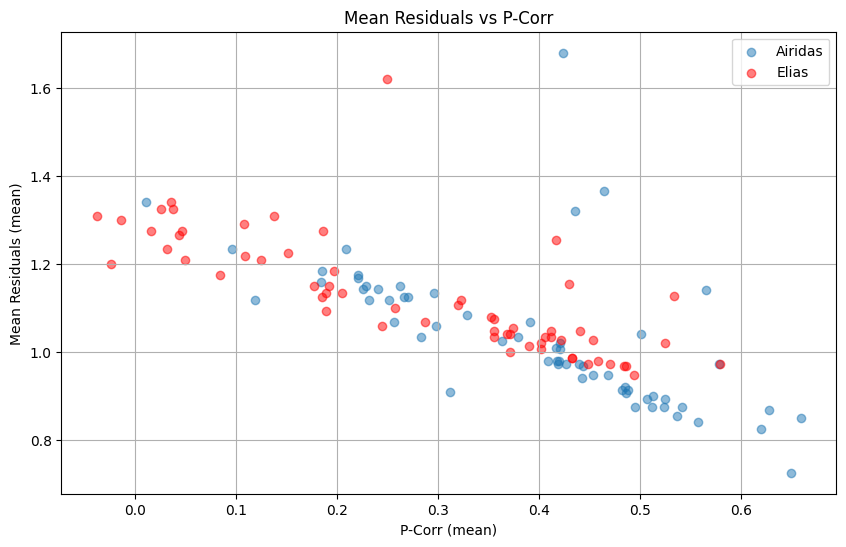

In [16]:
import matplotlib.pyplot as plt

# Assuming 'mean_residual_Airidas_mean' and 'p-corr_Airidas_mean' are already computed as mean values in your aggregated dataframe
# Plotting for Airidas
plt.figure(figsize=(10, 6))
plt.scatter(dfg['p-corr_Airidas_mean'], dfg['mean_residual_Airidas_mean'], label='Airidas', alpha=0.5)

# Assuming 'mean_residual_Elias_mean' and 'p-corr_Elias_mean' are also computed as mean values
# Plotting for Elias
plt.scatter(dfg['p-corr_Elias_mean'], dfg['mean_residual_Elias_mean'], color='red', label='Elias', alpha=0.5)

plt.title('Mean Residuals vs P-Corr')
plt.xlabel('P-Corr (mean)')
plt.ylabel('Mean Residuals (mean)')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/c_/tzd73j_x0cv7qzwc4gp6r0tm0000gn/T/ipykernel_7083/2242196719.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_airidas_personality, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[0, 0], palette=colors_airidas_p, orient='h')
/var/folders/c_/tzd73j_x0cv7qzwc4gp6r0tm0000gn/T/ipykernel_7083/2242196719.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_airidas_kano, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[1, 0], palette=colors_airidas_k, orient='h')
/var/folders/c_/tzd73j_x0cv7qzwc4gp6r0tm0000gn/T/ipykernel_7083/2242196719.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

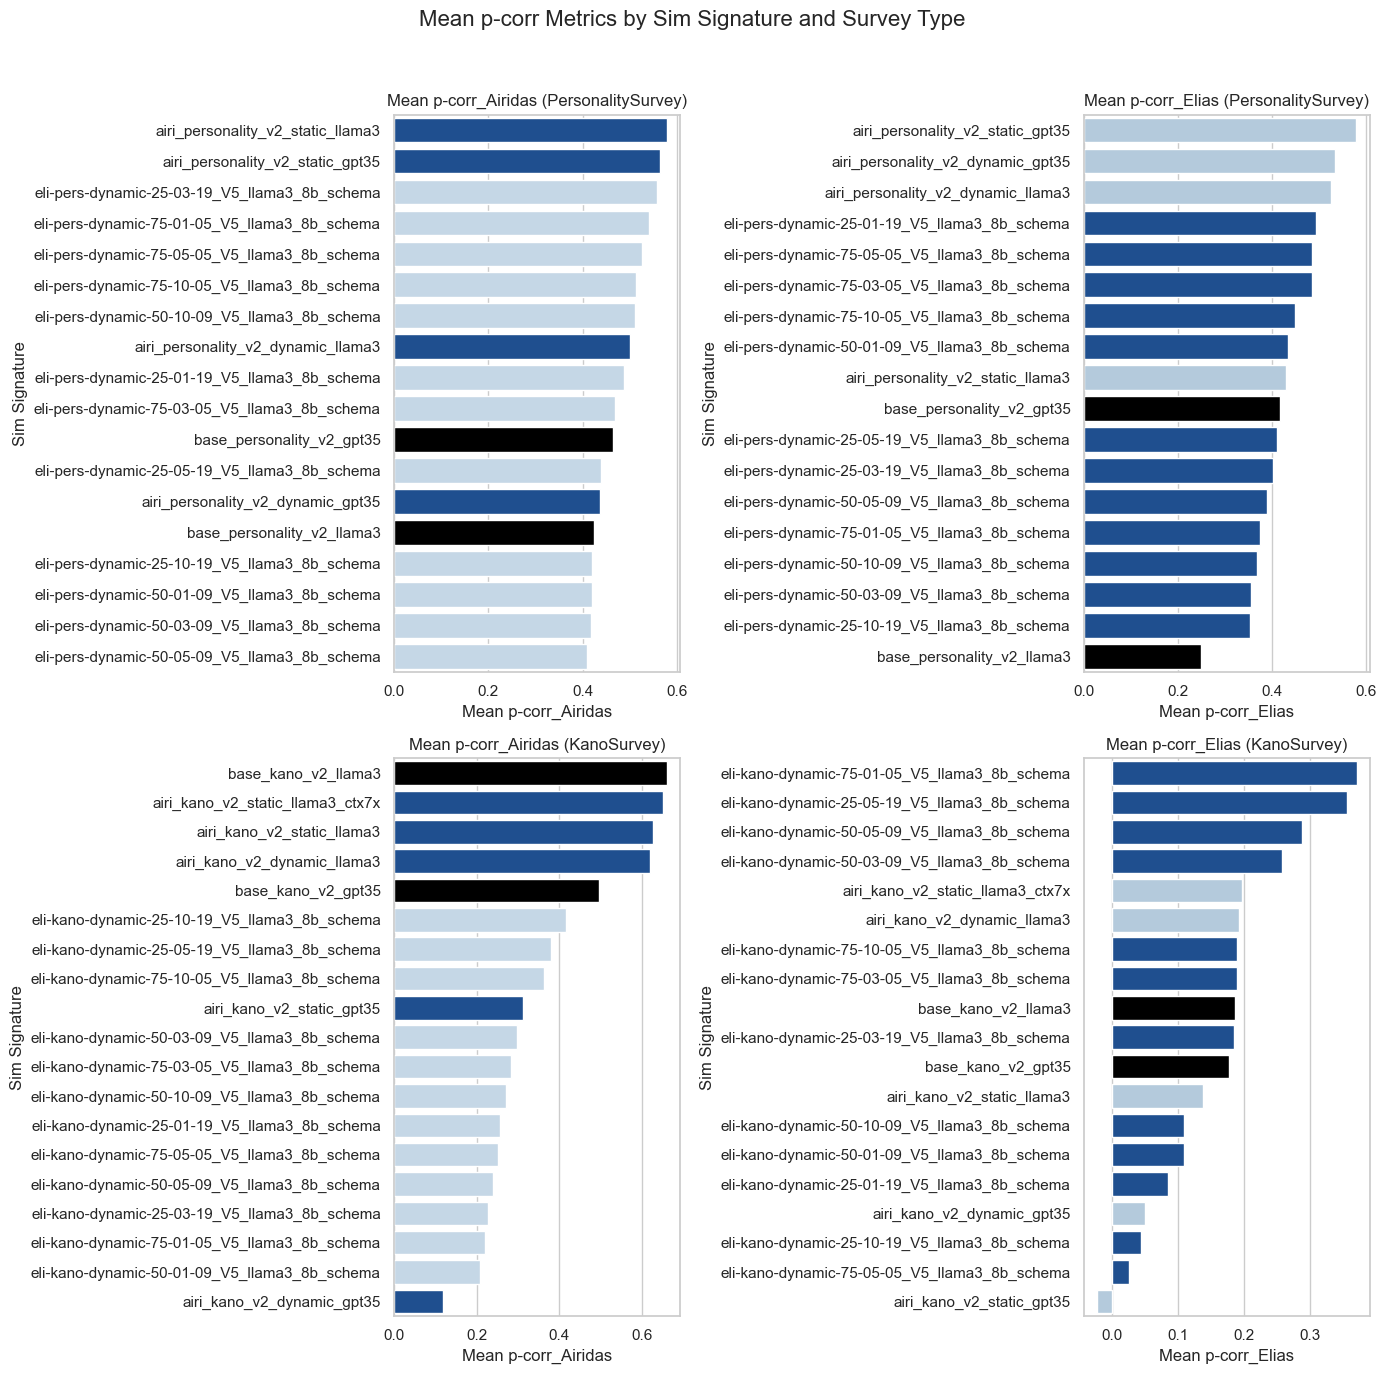

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dfg = dfg[dfg['retrieval method'] != "static"]
# Set style
sns.set(style="whitegrid")

# Sorting and filtering the dataframe for each plot
sorted_airidas_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('p-corr_Airidas_mean', ascending=False)
sorted_airidas_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('p-corr_Airidas_mean', ascending=False)
sorted_elias_personality = dfg[(dfg['survey_type'] == 'PersonalitySurvey')].sort_values('p-corr_Elias_mean', ascending=False)
sorted_elias_kano = dfg[(dfg['survey_type'] == 'KanoSurvey')].sort_values('p-corr_Elias_mean', ascending=False)

# Custom color function that also compares the 'SUBJECT' value
def get_colors_airidas(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'airidas' and not row['is_base']:
            colors.append('#bfd7ec')  # Color these bars black if 'SUBJECT' is not 'airidas'
        elif row['is_base']:
            colors.append('black')  # Soft tinted light blue
        else:
            colors.append('#0c4da2')  # Deep blue

    return colors

def get_colors_elias(df):
    colors = []
    for _, row in df.iterrows():
        if row['SUBJECT'] != 'elias' and not row['is_base']:
            colors.append('#adcbe3')  # Color these bars black if 'SUBJECT' is not 'elias'
        elif row['is_base']:
            colors.append('black')  # Soft tinted light blue
        else:
            colors.append('#0c4da2')  # Deep blue

    return colors

# Get colors for each dataset
colors_airidas_p = get_colors_airidas(sorted_airidas_personality)
colors_airidas_k = get_colors_airidas(sorted_airidas_kano)
colors_elias_p = get_colors_elias(sorted_elias_personality)
colors_elias_k = get_colors_elias(sorted_elias_kano)

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # 2 rows, 2 columns
fig.suptitle('Mean p-corr Metrics by Sim Signature and Survey Type', fontsize=16)

# Plotting as horizontal bar charts using sorted data and custom colors
sns.barplot(data=sorted_airidas_personality, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[0, 0], palette=colors_airidas_p, orient='h')
axs[0, 0].set_title('Mean p-corr_Airidas (PersonalitySurvey)')
axs[0, 0].set_xlabel('Mean p-corr_Airidas')
axs[0, 0].set_ylabel('Sim Signature')

sns.barplot(data=sorted_airidas_kano, y='sim_signature', x='p-corr_Airidas_mean', ax=axs[1, 0], palette=colors_airidas_k, orient='h')
axs[1, 0].set_title('Mean p-corr_Airidas (KanoSurvey)')
axs[1, 0].set_xlabel('Mean p-corr_Airidas')
axs[1, 0].set_ylabel('Sim Signature')

sns.barplot(data=sorted_elias_personality, y='sim_signature', x='p-corr_Elias_mean', ax=axs[0, 1], palette=colors_elias_p, orient='h')
axs[0, 1].set_title('Mean p-corr_Elias (PersonalitySurvey)')
axs[0, 1].set_xlabel('Mean p-corr_Elias')
axs[0, 1].set_ylabel('Sim Signature')

sns.barplot(data=sorted_elias_kano, y='sim_signature', x='p-corr_Elias_mean', ax=axs[1, 1], palette=colors_elias_k, orient='h')
axs[1, 1].set_title('Mean p-corr_Elias (KanoSurvey)')
axs[1, 1].set_xlabel('Mean p-corr_Elias')
axs[1, 1].set_ylabel('Sim Signature')

# Adjust layout for readability
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()

### Hyperparameter tuning analysis

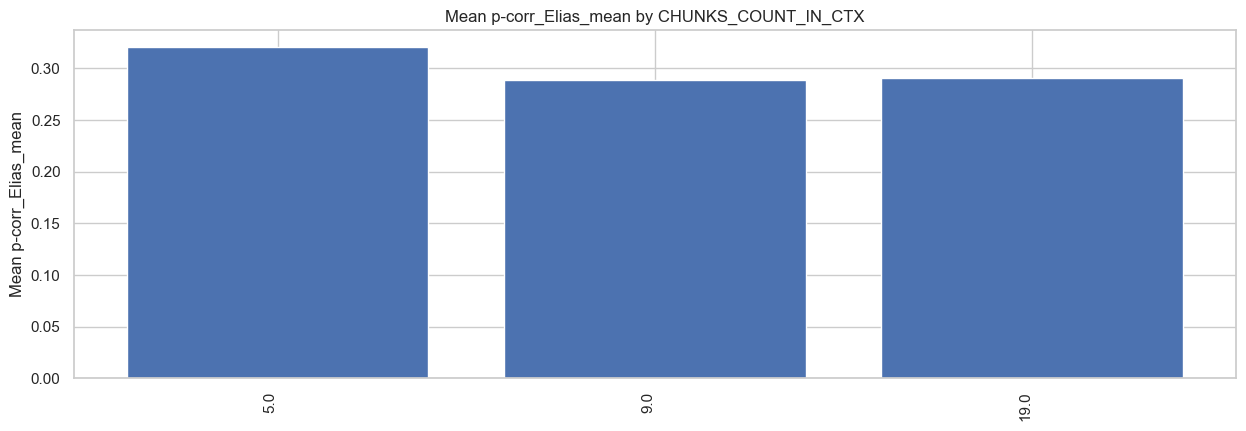

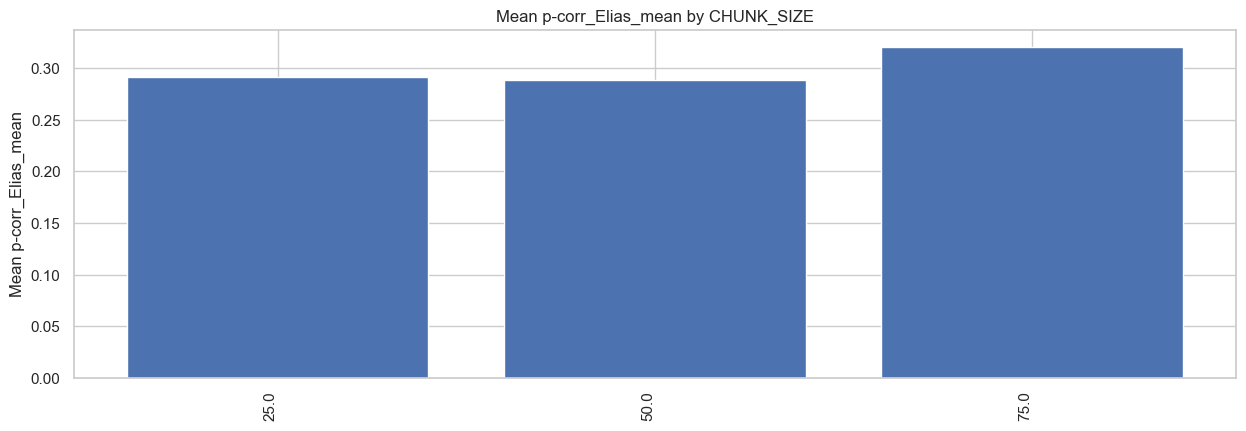

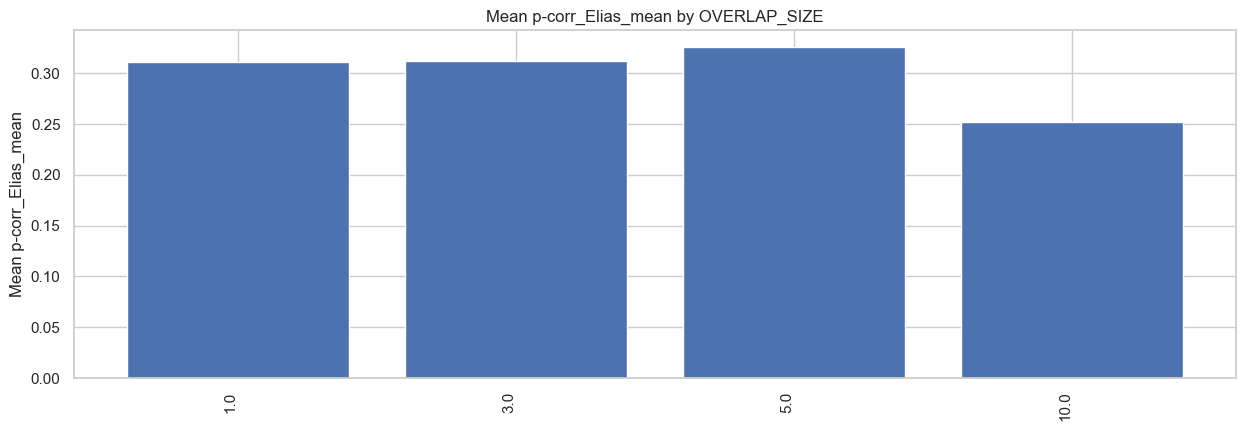

In [25]:
import matplotlib.pyplot as plt
import numpy as np
dfg = dfg[dfg['SUBJECT'] != "airidas"]
dfg = dfg[dfg['retrieval method'] == "dynamic"]
# Compute mean p-corr_Elias_mean for each unique value of 'CHUNKS_COUNT_IN_CTX'
chunks_count_means = dfg.groupby('CHUNKS_COUNT_IN_CTX')['p-corr_Elias_mean'].mean().reset_index()
chunks_count_means = chunks_count_means.sort_values(by='CHUNKS_COUNT_IN_CTX')

# Plot bar chart for 'CHUNKS_COUNT_IN_CTX'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(chunks_count_means)), chunks_count_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(chunks_count_means)), chunks_count_means['CHUNKS_COUNT_IN_CTX'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by CHUNKS_COUNT_IN_CTX')
plt.show()

# Compute mean p-corr_Elias_mean for each unique value of 'CHUNK_SIZE'
chunk_size_means = dfg.groupby('CHUNK_SIZE')['p-corr_Elias_mean'].mean().reset_index()
chunk_size_means = chunk_size_means.sort_values(by='CHUNK_SIZE')

# Plot bar chart for 'CHUNK_SIZE'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(chunk_size_means)), chunk_size_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(chunk_size_means)), chunk_size_means['CHUNK_SIZE'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by CHUNK_SIZE')
plt.show()

# Compute mean p-corr_Elias_mean for each unique value of 'OVERLAP_SIZE'
overlap_size_means = dfg.groupby('OVERLAP_SIZE')['p-corr_Elias_mean'].mean().reset_index()
overlap_size_means = overlap_size_means.sort_values(by='OVERLAP_SIZE')

# Plot bar chart for 'OVERLAP_SIZE'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(overlap_size_means)), overlap_size_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(overlap_size_means)), overlap_size_means['OVERLAP_SIZE'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by OVERLAP_SIZE')
plt.show()

In [239]:
import matplotlib.pyplot as plt
import numpy as np

# Drop rows where SUBJECT == "airidas"
dfg = dfg[dfg['SUBJECT'] != "airidas"]
dfg = dfg[dfg['retrieval method'] == "dynamic"]
# dfg = dfg[dfg['survey_type'] != "PersonaSurvey"]

# Compute mean p-corr_Elias_mean for each unique value of 'retrieval_method'
retrieval_method_means = dfg.groupby('retrieval method')['p-corr_Elias_mean'].mean().reset_index()
retrieval_method_means = retrieval_method_means.sort_values(by='retrieval method')

# Plot bar chart for 'retrieval_method'
plt.figure(figsize=(15, 6))
plt.bar(np.arange(len(retrieval_method_means)), retrieval_method_means['p-corr_Elias_mean'])
plt.xticks(np.arange(len(retrieval_method_means)), retrieval_method_means['retrieval method'], rotation=90, ha='right')
plt.subplots_adjust(bottom=0.3)
plt.ylabel('Mean p-corr_Elias_mean')
plt.title('Mean p-corr_Elias_mean by Retrieval Method')
plt.show()

KeyError: 'SUBJECT'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Drop rows where SUBJECT == "airidas"
dfg = dfg[dfg['SUBJECT'] != "airidas"]


# Compute mean p-corr_Elias_mean and mean_residual_Elias_std for each unique value of 'retrieval_method'
retrieval_method_means = dfg.groupby('retrieval method')[['p-corr_Elias_mean', 'mean_residual_Elias_std']].mean().reset_index()
retrieval_method_means = retrieval_method_means.sort_values(by='retrieval method')

# Plot bar chart for 'retrieval_method'
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.35
index = np.arange(len(retrieval_method_means))

rects1 = ax.bar(index, retrieval_method_means['p-corr_Elias_mean'], bar_width, label='p-corr_Elias_mean')
rects2 = ax.bar(index + bar_width, retrieval_method_means['mean_residual_Elias_std'], bar_width, label='mean_residual_Elias_std')

ax.set_xlabel('Retrieval Method')
ax.set_ylabel('Mean Value')
ax.set_title('Mean Values by Retrieval Method')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(retrieval_method_means['retrieval method'], rotation=90, ha='right')
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd
# Drop rows where SUBJECT == "airidas"
dfg = dfg[dfg['SUBJECT'] != "airidas"]
# Compute summary statistics for each retrieval method
summary_stats = dfg.groupby('retrieval method')[['p-corr_Elias_mean', 'mean_residual_Elias_std']].agg(['mean', 'var', 'std'])
# Reset the multi-index to make the column labels more readable
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.reset_index()
# Store the summary statistics in a DataFrame
pd.DataFrame(summary_stats)

In [ ]:
systemMsg( "You are participating in a survey. You will be presented with a series of questions about your video game preferrences.", f"You must choose answer to the question below with one of the five options: {', '.join(surv.POSSIBLE_ANSWERS)}. The answer must only contain the chosen option. " ), 
# Understanding affirmation 
assistantMsg('Understood. I will answer the question below with one of the given options.'), 
# Survey question. With Simulation 
userMsg( question, "Your choice: " ),

systemMsg("\\n".join([
            f"You are an expert actor, specializing in impersonation of non-famouns people. You will be presented to the subject through explicit datapoints of their digital footprint. In addition, you will deduct their implicit {SURVEY} by shadowing chats between the subject and friends. You will be asked to fully immerse yourself in the role, and answer questions from the point of view of the persona. \\n#Context \\n##Chat conversations between the subject and their friends:\\n**From most to least related**\\n",
            "\\n\\nNEW CONVERSATION:\\n".join(chunks_most_similar)
        ])),      
        assistantMsg("Understood. I will answer from the point of view of the persona, based on what I could the deduct from the text provided."),
        userMsg("\\n".join([
            f"Persona is questioned about their {SURVEY} in an {METHOD}. The persona must choose an appropriate answer to the question below with one of these five given options: {', '.join(surv.POSSIBLE_ANSWERS)}. Persona's answer must only contain the chosen option, without any elaboration, nor introduction.\\n\\n**Your question is:**\\n",
            question,
            "\\nThe persona chooses:"
        ]))]

### THE REAL DEAL

In [ ]:
# ################### Retrieval below ##################
surv = {}
surv['POSSIBLE_ANSWERS'] = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]

def extract_possible_answer(value):
    for phrase in surv['POSSIBLE_ANSWERS']:
        pattern = r'(?i)' + re.escape(phrase)
        match = re.search(pattern, value)
        if match:
            return match.group()
    return value  # Return the original value if no possible answer is found

############ Invalid Answers ##################
def get_invalid_answers(value):
    if pd.isna(value):
        return ""
    elif value == "NaN":
        return ""
    elif value in surv['POSSIBLE_ANSWERS']:
        return ""
    else:
        return value
    
# surv = survey.PersonalitySurvey()
# surv = survey.KanoSurvey()

## Convert Personality survey As into Big 5 ratings

In [ ]:
# Load the simulation results
# both personality and game WIP

dfs = []
filenames = []
# changed_values_per_column = {}

# List of folder paths
# folder_paths = ['simulations/local/video-game/', 'simulations/local/personality/']
# folder_paths = ['batch/output/_pers']
folder_paths = ['batch/output/llama3_70b/kano']#, 'batch/output/_pers']
# pers_folder_path = ['batch/output/_pers']
# kano_folder_path = ['batch/output/_kano']

# Read the first CSV file from the first folder to get the 'question' column
first_folder_path = folder_paths[0]
first_file_path = os.path.join(first_folder_path, os.listdir(first_folder_path)[0])
first_df = pd.read_csv(first_file_path)
questions = first_df['question']
# csv_loop_counter = 0

for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            # Store the original 'answer' column
            # original_answers = df['answer'].copy()
            
            # # remove all characters from a black list from the column answer
            df['answer'] = df['answer'].apply(lambda x: x.strip())
            for substr in utils.BLACKLIST_ANSWER_SUBSTRINGS:
                df['answer'] = df['answer'].apply(lambda x: re.sub(substr, "", x))
            df['answer'] = df['answer'].str.upper()
            df['answer'] = df['answer'].apply(extract_possible_answer)
            # df['answer'] = df['answer'].apply(get_invalid_answers)
            
            filename_without_ext = filename[:-4]  # Remove the '.csv' extension
            filename_without_simulation = (
                filename_without_ext.replace('_simulation', '')
                                    # .replace('video-', '')
            )  # Remove '_simulation' from the filename
            filenames.append(filename_without_simulation)
            dfs.append(df['answer'])
            # csv_loop_counter += 1

answers_df = pd.concat(dfs, axis=1, keys=filenames)
# answers_df.insert(0, 'question', questions)  # Insert the 'question' column at the beginning
#print(f"Values changed: {changed_format}")
df = answers_df
df[:6]

In [ ]:
REMAP_MISSING_E = {"AGRE": "AGREE", "SOMEWHAT AGRE": "SOMEWHAT AGREE", "SOMEWHAT DISAGRE": "SOMEWHAT DISAGREE", "DISAGRE": "DISAGREE"}
df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: REMAP_MISSING_E.get(x, x))

#### SURVEY (both PERSONALITY and KANO)

In [ ]:
surv = survey.KanoSurvey()
# df['isValid'] = df['answer'].apply(lambda x: x in surv.POSSIBLE_ANSWERS)
# df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: remap_dict.get(x, x))
df['isValid'] = df.iloc[:, 1:].map(lambda x: x in surv.POSSIBLE_ANSWERS).all(axis=1)
if df['isValid'].all():
    df = df.drop('isValid', axis=1)
    print("All answers were valid")
else:
    print("Some answers were not valid")
df.head()

In [ ]:
# surv = survey.PersonalitySurvey()
# surv = survey.KanoSurvey()

# # Add airidas and elias answers
# air = surv.test_answers["airidas"]
# answers_df.insert(1, "airidas", air[:len(df)])
eli = surv.test_answers["elias"]
df.insert(0, "elias", eli[:len(df)])

# df['answer'] = df['answer'].str.upper()
# df['elias'] = df['elias'].str.upper()
# df = df.dropna()
# df[:5]

### Process data

##### Str2Int

In [ ]:
### Remaps - UNIVERSAL
if isinstance(surv, survey.KanoSurvey):
    remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: remap_dict.get(x, x))
    # df['answer'] = df['answer'].map(remap_dict)
    # df['airidas'] = df['airidas'].map(remap_dict)
    # df['elias'] = df['elias'].map(remap_dict)
elif isinstance(surv, survey.PersonalitySurvey):
    remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: remap_dict.get(x, x))
    # df.iloc[:, 2:] = df.iloc[:, 2:].map(lambda x: remap_dict[x])
    # remap_cols = df.columns[df.columns.str.contains('|'.join(remap_dict.keys()))]    
    # df['answer'] = df['answer'].map(remap_dict)

df[:2]

In [ ]:
df['elias'] = df['elias'].str.upper()
df['elias'] = df['elias'].map(remap_dict)
df.head()

In [ ]:
# Get correlations with 'elias'
correlations = df.corr()['elias']

# Drop the correlation of 'elias' with itself
correlations = correlations.drop('elias')

# Convert the Series to a DataFrame
new_df = correlations.to_frame().reset_index()

# Rename the columns
new_df.columns = ['column_name', 'correlation']

new_df.to_csv("kano_llama3_70b.csv")

#### SHIT...

In [ ]:
# df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: int(x) if not pd.isna(x) else x)
# df.iloc[:, 1:] = df.iloc[:, 1:].astype(pd.Int64Dtype())

In [ ]:
import pandas as pd
# df.count_non_matching_fields(df, _PersonalitySurvey_)

def count_non_matching_fields(df, surv):
    if isinstance(surv, survey._KanoSurvey_):
        remap_dict = {"I EXPECT IT": 5, "I LIKE IT": 4, "I AM NEUTRAL": 3, "I CAN TOLERATE IT": 2, "I DISLIKE IT": 1}
        possible_answers = list(remap_dict.keys())

        non_matching_counts = (
            df.iloc[:, 1:]
            .applymap(lambda x: x not in possible_answers)
            .sum()
            .rename("non_matching_count")
        )

        df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: remap_dict.get(x, x))

    elif isinstance(surv, survey._PersonalitySurvey_):
        remap_dict = {"AGREE": 5, "SOMEWHAT AGREE": 4, "NEUTRAL": 3, "SOMEWHAT DISAGREE": 2, "DISAGREE": 1}
        possible_answers = list(remap_dict.keys())

        non_matching_counts = (
            df.iloc[:, 2:]
            .applymap(lambda x: x not in possible_answers)
            .sum()
            .rename("non_matching_count")
        )

        df.iloc[:, 2:] = df.iloc[:, 2:].applymap(lambda x: remap_dict.get(x, x))

    return non_matching_counts
df.head()


In [ ]:
# Assuming your DataFrame is named 'df'
for col in df.columns[1:]:  # Iterate over all columns except the target column
    matches = df.loc[df[col] == df['elias'], col]  # Find rows where values match the target
    print(f"Exact matches for column '{col}': {len(matches)}")

# Compute correlation between each column and the target column
correlations = df.corr()['elias'].drop('elias')
print(correlations)

for col in df.columns[1:]:
    matches = df.loc[df[col] == df['elias'], col]
    print(f"Exact matches for column '{col}': {len(matches)}")

correlations = df.corr()['elias'].drop('elias')
print("\nCorrelations:")
print(correlations)

In [ ]:
df.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

# Assuming 'col1' and 'col2' have the highest positive and negative correlations, respectively
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['eli_pers_static-IMPERSONATE_5'], df['elias'])
plt.xlabel('eli_pers_static-IMPERSONATE_5')
plt.ylabel('elias')
plt.title('Scatter Plot: eli_pers_static-IMPERSONATE_5 vs. elias')

plt.subplot(1, 2, 2)
plt.scatter(df['eli_pers_static-ARE_1'], df['elias'])
plt.xlabel('eli_pers_static-ARE_1')
plt.ylabel('elias')
plt.title('Scatter Plot: eli_pers_static-ARE_1 vs. elias')

plt.tight_layout()
plt.show()

In [ ]:
df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: remap_dict.get(x, x))

In [ ]:
valid_answers = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]#surv['POSSIBLE_ANSWERS']
# Assuming you have a DataFrame 'df' with columns ['col1', 'col2', 'elias', 'col3', 'col4', ...]
# and a set 'valid_answers' containing the valid answer values
# Get the column names except the first two  and 'elias'
cols = [col for col in df.columns[0:] if col != 'elias']
# Create a dictionary to store the computed values
results = {}
# Function to compute "Exact Matches"
def exact_matches(col):
    # Filter the rows where both columns have valid answers
    valid_rows = (df[col].isin(valid_answers)) & (df['elias'].isin(valid_answers))
    # Compute exact matches only for valid rows
    return (df.loc[valid_rows, col] == df.loc[valid_rows, 'elias']).mean()
# Function to compute "Correlation"
def correlation(col):
    # Filter the rows where both columns have valid answers
    valid_rows = (df[col].isin(valid_answers)) & (df['elias'].isin(valid_answers))
    # Compute correlation only for valid rows
    return df.loc[valid_rows, col].corr(df.loc[valid_rows, 'elias'])
# Compute the "Exact Matches" and "Correlation" for each column against 'elias'
for col in cols:
    key1 = f"Exact Matches - {col} vs elias"
    key2 = f"Correlation - {col} vs elias"
    results[key1] = exact_matches(col)
    results[key2] = correlation(col)
# Sort the columns by their correlation with 'elias' in descending order
sorted_cols = sorted(cols, key=lambda col: results[f"Correlation - {col} vs elias"], reverse=True)
# Print the results sorted by correlation, from highest to lowest
for col in sorted_cols:
    em_key = f"Exact Matches - {col} vs elias"
    corr_key = f"Correlation - {col} vs elias"
    print(f"{col}: Exact Matches = {results[em_key]}, Correlation = {results[corr_key]}")

##### Embed technique

In [ ]:
############ Embed technique ################
# RETRIEVAL_PROMPT = surv['POSSIBLE_ANSWERS']
PRE_DEF_ANSWERS = ["I LIKE IT", "I EXPECT IT", "I AM NEUTRAL", "I CAN TOLERATE IT", "I DISLIKE IT", "SOMEWHAT DISAGREE", "DISAGREE", "NEUTRAL", "SOMEWHAT AGREE", "AGREE"]

embeddings = [ollama.embeddings(model=EMBED_MODEL, prompt=answer)["embedding"] for answer in PRE_DEF_ANSWERS]

FINAL_STRINGS_2_CLEAN = df['answer'] #change to answers_df['answer'] for all simulations
# utils.find_most_similar(ollama.embeddings(model=EMBED_MODEL, prompt=FINAL_STRINGS_2_CLEAN[0])["embedding"], embeddings)
mapped_results = [utils.find_most_similar(string) for string in FINAL_STRINGS_2_CLEAN]
print(mapped_results)
# Generate embeddings for each chunk
embeddings = []

progress, chunks_len = 0, len(chunks) # for progress bar
for chunk_text in chunks:
    progress += 1
    print(f"\rChunk {progress}/{chunks_len}", end="")

    embedding = ollama.embeddings(model=EMBED_MODEL, prompt=chunk_text)["embedding"]
    embeddings.append(embedding)

bu.if_dir_not_exist_make("data/3_embeddings")
bu.quickJSON(AUTO_INFO, f"data/3_embeddings/POSSIBLE_ANSWERS_info.json")
bu.quickJSON({"chunks": chunks, "embeddings": embeddings}, f"data/3_embeddings/POSSIBLE_ANSWERS_embeddings.json")

##### Trash?

In [ ]:
# Import simulation and info sheet
SIMULATION_NAMEID = "airidas-personality_mixtral_cv1" #f"{SIM_ID}"
df = pd.read_csv(f'simulations/local/personality/{SIMULATION_NAMEID}_simulation.csv')
with open(f'simulations/local/personality/{SIMULATION_NAMEID}_info.json', 'r') as f:
    loaded = json.load(f)
try:
    AUTO_INFO = loaded["info"]
    SETTINGS = loaded["settings"]
    print("Settings and info loaded:")
    for k, v in AUTO_INFO.items():
        print(f"{k}: {v}")
    for k, v in SETTINGS.items():
        print(f"{k}: {v}")
except:
    print("No settings and/or info found")
try:
    if str(type(surv)) != AUTO_INFO["survey_type"]:
        print(f"WARNING: surv variable is not of the same type. {str(type(surv))} != {AUTO_INFO['survey_type']}")
except:
    pass
df.head(n=2)

In [ ]:
# LiveCSV
bu.if_dir_not_exist_make("data/6_sim-clean/results")
res = bu.LiveCSV(f"data/6_sim-clean/elias_runs.csv")

# survey = survey.PersonalitySurvey()
non_matching_counts = count_non_matching_fields(df, surv)
print(non_matching_counts)

In [ ]:
# compute one number of how the percentage of correct answers
result_data = {
    # "Exact Matches - airi": (df['answer'] == df['airidas']).sum() / len(df),
    # "Correlation - airi": df['answer'].corr(df['airidas']),
    "Exact Matches - eli": (df['answer'] == df['elias']).sum() / len(df),
    "Correlation - eli": df['answer'].corr(df['elias']),
}
# compute one number of how the percentage of correct answers
# print(f"Exact Matches: {(df['CLONE_eli'] == df['IRL_eli']).sum() / len(df)}")
# print(f"Correlation: {df['CLONE_eli'].corr(df['IRL_eli'])}")
# df['elias_correct'] = df['CLONE_eli'] == df['IRL_eli']
df.iloc[:, 2:] = df.iloc[:, 2:].applymap(lambda x: remap_dict.get(x, x))
for k, v in result_data.items():
    print(f"{k}: {v}")


In [ ]:
new_res = {
    # "label": None,
    "SIMULATION_NAMEID": SIMULATION_NAMEID,#SIM_ID,
    "timestamp": bu.get_timestamp(),
    "survey_type": str(type(surv)),
    # "temperature": SETTINGS["temperature"],
    # "note": "",
    "exact_matches": result_data["Exact Matches"],
    "corr": result_data["Correlation"],
    "exact_matches_elias": result_data["Exact Matches - elias"],
    "corr_elias": result_data["Correlation - elias"],
}

tmp = bu.convert_dicts_to_table([new_res])
res.append_data(tmp[1], tmp[0])

##### Cleaning

In [ ]:
# def _get_invalid_answers_(value, surv, invalid_answers_df=None):
#   --||---
#     else:
#         if invalid_answers_df is None:
#             invalid_answers_df = pd.DataFrame({'invalid_answer': [value]})
#         elif invalid_answers_df is not None:
#             invalid_answers_df = invalid_answers_df.append({'invalid_answer': value}, ignore_index=True)
#         else:
#             new_row = pd.DataFrame({'invalid_answer': [value]})
#             invalid_answers_df = pd.concat([invalid_answers_df, new_row], ignore_index=True)
#         return value

#################### ^Retrieval ^ ####################
################ VALIDATION #############
for value in values:
    result = _get_invalid_answers_(value, surv, invalid_answers_df)
    if result == "":
        continue
    elif isinstance(result, pd.DataFrame):
        invalid_answers_df = result
    else:
        print(result)

invalid_answers_df = pd.DataFrame.append(invalid_answers_df, pd.DataFrame({'invalid_answer': [value]}), ignore_index=True)
invalid_answers_df = pd.DataFrame(columns=['invalid_answer'])
# Update isValid
df['isValid'] = df['answer'].apply(lambda x: x in surv.POSSIBLE_ANSWERS)
# ################ VALIDATION #############

In [ ]:
# df['airidas'] = df['airidas'].str.upper()
# df['elias'] = df['elias'].str.upper()
# df['answer'] = df['answer'].map(remap_dict)
# df['airidas'] = df['airidas'].map(remap_dict)
# df['elias'] = df['elias'].map(remap_dict)
########################
# df = df.drop(columns=['uppercase_text'])
# df['CLONE_eli'] = df['answer'].apply(extract_uppercase_text)
# df['CLONE_eli'] = df['CLONE_eli'].str.upper()
# .str.upper() or .lower()
# df['answer'] = df['answer'].map(remap_dict, na_action='ignore')
#df['CLONE_eli'] = df['CLONE_eli'].fillna(0).astype(int)